In [1]:
%matplotlib inline
#! switch_R 3.3
%load_ext rpy2.ipython

In [2]:
from __future__ import division
from copy import deepcopy
import math
import numpy as np
import pandas as pd
import pygam
import statsmodels.stats.api as sms
from pyspan import cross_validation as cv
from pyspan.ratings_task.analysis import freq_df, n_utterances, signal_df, SparseLR
from pyspan.synonyms.data import *
words_original = deepcopy(words)
words = words.loc[words.index != 7]
from pyspan.utils import *
from pyspan.valence import get_valence
signals = pickle.load(open(paths["metrics_dir"] + "signals-unigrams", 
                           "rb"))

/Users/sabinasloman/Box/LoP/pyspan/pyspan/config.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  

In [3]:
data = pd.read_csv("responses.csv")
# After excluding fear vs. terror, these are the indices we're using
ixs = range(7) + range(8,26)

data.rename(columns = dict(zip(map(str, ixs), ixs)), inplace = True)
pair_cols = map(lambda i: "pair{}".format(i), ixs)

In [4]:
def calc_accuracy(word):
    polarity = signals.loc[word].rmetric > 0
    mask = np.ma.masked_where(data[pair_cols] == word, data[ixs])
    dat = mask.data[mask.mask]
    judgments = dat[~np.isnan(dat)]
    return len(judgments[judgments > 2.5 if polarity else judgments < 2.5]), len(judgments)
v_calc_accuracy = np.vectorize(calc_accuracy)

In [5]:
items = np.ravel(words[["D","R"]].values)
p, n = v_calc_accuracy(items)
p = p / n
band_height = 1.96 * np.sqrt(p * (1 - p) / n)

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


/Users/sabinasloman/Box/LoP/pyspan/output/crec_debates_word_signals_accuracy


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x141be4f10>)

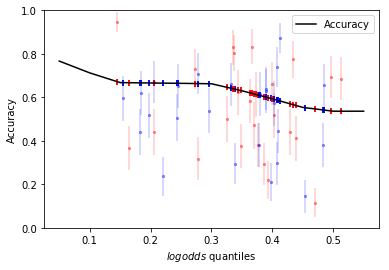

In [6]:
cv.plot_("crec", "debates", "word", words = zip(items, p, band_height))

Participant demographics

In [7]:
len(data.loc[data.party == "Democrat"]), len(data.loc[data.party == "Republican"]), \
len(data.loc[~(data.party.isin(["Democrat","Republican"]))])

(77, 45, 52)

In [8]:
print np.mean(data.age[~np.isnan(data.age)]), stats.sem(data.age[~np.isnan(data.age)])
print len(data.loc[data.gender == "Male"]), len(data.loc[data.gender == "Female"])
print np.mean(data.voted)

40.35057471264368 0.8672733959927182
88 85
0.847953216374269


Testing the difference in means

In [9]:
dmask = np.ma.masked_where(data[pair_cols].isin(words["D"].values), data[ixs])
ddat = dmask.data[dmask.mask]
rmask = np.ma.masked_where(data[pair_cols].isin(words["R"].values), data[ixs])
rdat = rmask.data[rmask.mask]

In [10]:
np.mean(rdat[~np.isnan(rdat)]), stats.sem(rdat[~np.isnan(rdat)])

(2.6966343937298296, 0.029210696167390728)

In [11]:
np.mean(ddat[~np.isnan(ddat)]), stats.sem(ddat[~np.isnan(ddat)])

(2.4944802207911683, 0.028965175835954794)

In [12]:
np.mean(rdat[~np.isnan(rdat)]) - np.mean(ddat[~np.isnan(ddat)])

0.20215417293866134

In [13]:
ddat_ = dmask.data.copy().astype("float")
ddat_[~dmask.mask] = np.nan
rdat_ = rmask.data.copy().astype("float")
rdat_[~rmask.mask] = np.nan

Analysis of variance

In [14]:
%%R -i ddat_,rdat_
# https://www.r-bloggers.com/how-to-do-repeated-measures-anovas-in-r/
y <- c(t(ddat_), t(rdat_))
n <- dim(ddat_)[1]
stopifnot(n == dim(rdat_)[1])
kd <- dim(ddat_)[2]
kr <- dim(rdat_)[2]
clusters <- c(rep(1:n, each = kd), rep(1:n, each = kr))
groups <- c(rep(0, n*kd), rep(1, n*kr))
fit <- aov(y ~ groups + Error(clusters/groups))
summary(fit)

library(lmerTest)
fit <- lmer(y ~ groups + (1|clusters))
anova(fit)

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lme4

  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘lmerTest’


  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:lme4’:

    lmer


  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is

Type III Analysis of Variance Table with Satterthwaite's method
       Sum Sq Mean Sq NumDF  DenDF F value    Pr(>F)    
groups 42.378  42.378     1 4338.9  23.603 1.226e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Compute an individual-level effect size and test the hypothesis that it's greater than 0.

In [15]:
def participant_diff(i):
    djudgments = dmask.data[i,dmask.mask[i,:]]
    djudgments = djudgments[~np.isnan(djudgments)]
    rjudgments = rmask.data[i,rmask.mask[i,:]]
    rjudgments = rjudgments[~np.isnan(rjudgments)]
    return cohensd(rjudgments, djudgments)
    
participant_diff = np.vectorize(participant_diff)

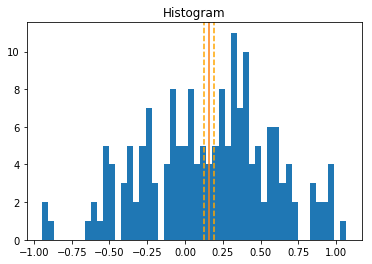

In [16]:
pdiffs = participant_diff(np.arange(len(data)))
hist, mu, se = histogram(pdiffs)

In [17]:
mu, se

(0.1573932224670715, 0.03179973113791762)

In [18]:
t, p = stats.ttest_1samp(pdiffs, 0)
t, p / 2

(4.949514251691194, 8.776095043328314e-07)

In [19]:
len(pdiffs) - 1

173

Mann-Whitney U test

For each word, compute the mean of the judgments across subjects.

In [20]:
def compute_mean_judgment(word):
    mask = np.ma.masked_where(data[pair_cols] == word, data[ixs])
    dat = mask.data[mask.mask]
    return np.mean(dat[~np.isnan(dat)])
vf = np.vectorize(compute_mean_judgment)
dmeans = vf(words["D"])
dmeans = dmeans[~np.isnan(dmeans)]
rmeans = vf(words["R"])
rmeans = rmeans[~np.isnan(rmeans)]

Rank the words by their associated mean judgment.

In [21]:
# Create a sequence of "D"s and "R"s that's ordered by mean judgment
means = list(zip(dmeans, ["D"] * len(ixs))) + list(zip(rmeans, ["R"] * len(ixs)))
means_sorted = sorted(means, key = lambda mu: mu[0])
seq = [ mu[1] for mu in means_sorted ]

Perform a Mann-Whitney U test to determine whether the Republican words are as likely to have a higher rank than Democratic words as to have a lower rank.

In [22]:
stats.mannwhitneyu(dmeans, rmeans, alternative = "less")

MannwhitneyuResult(statistic=256.0, pvalue=0.1386157438086561)

Fixed-effects logistic model

Binarize judgments into "more likely that the word was spoken by a Republican" ("REPUBLICAN"; rating >= 3) and "more likely that the word was spoken by a Democrat" (rating < 3).

Estimate the following logistic regression model (with participant-level effects): REPUBLICAN ~ Dummy indicating whether the word is Republican + Valence of word + Participant's party identity + Valence of word * Participant's party identity

In [23]:
lr_data = data.copy()
lr_data = lr_data.loc[lr_data.party.isin([ "Democrat", "Republican" ])]

n = len(lr_data)
# Add dummy columns
for i in range(1, n):
    ids = np.zeros(n)
    ids[i] = 1
    lr_data["participant{}".format(i)] = ids
    
Y_full = np.ravel(lr_data[ixs])
Y = Y_full > 2.5
X = np.full((n * len(ixs), 5 + n - 1), np.nan)
# Dummy indicating whether the word is Republican
vf = np.vectorize(lambda word: int(word in words["R"]))
X[:,0] = vf(np.ravel(lr_data[pair_cols]))
# Valence of word
vf = np.vectorize(lambda word: get_valence(word)[0]-5)
X[:,1] = vf(np.ravel(lr_data[pair_cols])) - 5
# Participant's political identity
vf = np.vectorize(lambda pid: int(pid == "Republican"))
pids = np.repeat(vf(lr_data.party), len(ixs))
pids[pids == 0] = -1
X[:,2] = pids
# Valence of word * Participant's party identity
X[:,3] = X[:,1] * np.array([ x if x != 0 else -1 for x in X[:,2] ])
for i in range(4, 4 + n - 1):
    X[:,i] = np.repeat(lr_data["participant{}".format(i-3)], len(ixs))
# The log odds that the word was said by a Republican
vf = np.vectorize(lambda word: signals.loc[word]["rmetric"])
X[:,-1] = vf(np.ravel(lr_data[pair_cols]))

Y = Y[~np.isnan(Y_full)]
X = X[~np.isnan(Y_full)]
Y_full = Y_full[~np.isnan(Y_full)]
X = X[~np.isnan(Y)]
Y_full = Y_full[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]
Y = Y[~np.isnan(X).any(axis = 1)]
Y_full = Y_full[~np.isnan(X).any(axis = 1)]
X = X[~np.isnan(X).any(axis = 1),:]

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


In [24]:
logit = SparseLR(Y, X[:,:-1]); logit.coef[:4]

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([ 0.        , -0.11771615,  0.65197244,  0.08770673])

In [25]:
len(Y), logit.auc

(2498, 0.6394923805766449)

Including continuous $logodds$ values instead of binary indicators as IVs.

Estimate the following logistic regression model (with participant-level effects): REPUBLICAN ~ Log odds that the word was said by a Republican + Valence of word + Participant's party identity + Valence of word * Participant's party identity

In [26]:
logit = SparseLR(Y, X[:,np.append(-1, np.arange(1, X.shape[1]))]); logit.coef[:4]

array([ 0.00068465, -0.10951589,  0.65253622,  0.08751931])

In [27]:
logit.auc

0.6533574537558257

Generalized additive model.

In [28]:
X_ = deepcopy(X[:,:-1])
# Run using the log odds that the word was said by a Republican rather
# than the binary indicator
X_[:,0] = X[:,-1]

In [29]:
logistic_gam = pygam.LogisticGAM(pygam.terms.TermList(*[pygam.s(0), pygam.s(1), 
                                 pygam.f(2), pygam.s(3)] + 
                                 [pygam.f(i) for i in range(4, 125)]))
logistic_gam.fit(X_, Y)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + f(16) + f(17) + f(18) + f(19) + f(20) + f(21) + f(22) + f(23) + f(24) + f(25) + f(26) + f(27) + f(28) + f(29) + f(30) + f(31) + f(32) + f(33) + f(34) + f(35) + f(36) + f(37) + f(38) + f(39) + f(40) + f(41) + f(42) + f(43) + f(44) + f(45) + f(46) + f(47) + f(48) + f(49) + f(50) + f(51) + f(52) + f(53) + f(54) + f(55) + f(56) + f(57) + f(58) + f(59) + f(60) + f(61) + f(62) + f(63) + f(64) + f(65) + f(66) + f(67) + f(68) + f(69) + f(70) + f(71) + f(72) + f(73) + f(74) + f(75) + f(76) + f(77) + f(78) + f(79) + f(80) + f(81) + f(82) + f(83) + f(84) + f(85) + f(86) + f(87) + f(88) + f(89) + f(90) + f(91) + f(92) + f(93) + f(94) + f(95) + f(96) + f(97) + f(98) + f(99) + f(100) + f(101) + f(102) + f(103) + f(104) + f(105) + f(106) + f(107) + f(108) + f(109) + f(110) + f(111)

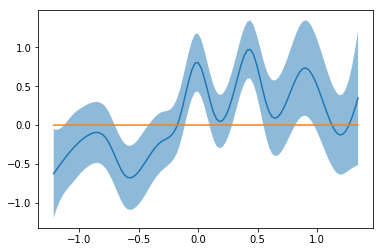

In [30]:
plot_prf(logistic_gam, 0, logit.coef[0])

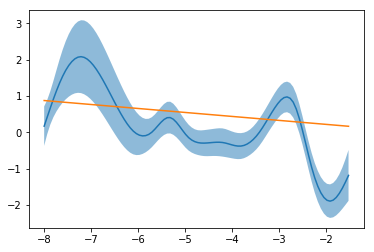

In [31]:
plot_prf(logistic_gam, 1, logit.coef[1])

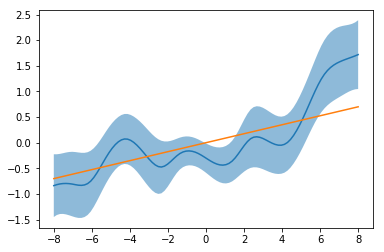

In [32]:
plot_prf(logistic_gam, 3, logit.coef[3])

Linear model

Same as the LR, but a linear model of the full ratings scale.

In [33]:
lm = sm.OLS(Y_full, sm.add_constant(X[:,:-1]))
res = lm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     2.569
Date:                Thu, 30 Apr 2020   Prob (F-statistic):           2.43e-17
Time:                        15:39:34   Log-Likelihood:                -4223.2
No. Observations:                2498   AIC:                             8694.
Df Residuals:                    2374   BIC:                             9417.
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9548      0.167     11.728      0.000       1.628       2.282
x1          2.287e-14      2e-14      1.146      0.252   -1.63e-14     6.2e-14
x2            -0.1225      0.018     -6.695      0.000      -0.158      -0.087
x3             0.5508      0.167      3.304      0.001       0.224       0.878
x4             0.1181      0.018      6.456      0.000       0.082       0.154
x5             0.1195      0.299      0.400      0.690      -0.467       0.706
x6             0.2264      0.421      0.538      0.590      -0.598       1.051
x7             0.2685      0.292      0.920      0.358      -0.304       0.841
x8            -0.1220      0.292     -0.418      0.676      -0.694       0.450
x9             0.2394      0.299      0.801      0.423      -0.347       0.826
x10            0.1055      0.299      0.353      0.724      -0.481       0.692
x11           -0.2203      0.299     -0.737      0.461      -0.807       0.366
x12            0.2367      0.416      0.570      0.569      -0.578       1.051
x13           -1.0209      0.292     -3.498      0.000      -1.593      -0.449
x14            0.5713      0.292      1.957      0.050      -0.001       1.144
x15            0.2228      0.299      0.745      0.456      -0.364       0.809
x16           -0.1358      0.299     -0.454      0.650      -0.722       0.450
x17            0.4755      0.415      1.145      0.252      -0.339       1.290
x18            0.1182      0.299      0.395      0.693      -0.468       0.704
x19           -0.0165      0.292     -0.057      0.955      -0.589       0.556
x20           -0.0962      0.292     -0.330      0.742      -0.669       0.476
x21            0.0815      0.299      0.273      0.785      -0.505       0.668
x22            0.0663      0.292      0.227      0.820      -0.506       0.639
x23            0.0947      0.299      0.317      0.751      -0.492       0.681
x24            0.2256      0.421      0.536      0.592      -0.599       1.050
x25           -0.2242      0.292     -0.768      0.443      -0.797       0.348
x26            0.3637      0.299      1.217      0.224      -0.223       0.950
x27            0.1737      0.292      0.595      0.552      -0.399       0.746
x28            0.5255      0.421      1.249      0.212      -0.299       1.350
x29            0.6187      0.415      1.489      0.137      -0.196       1.433
x30            0.0781      0.292      0.268      0.789      -0.494       0.650
x31           -0.0824      0.299     -0.276      0.783      -0.669       0.504
x32            0.0328      0.292      0.112      0.911      -0.540       0.605
x33            0.0894      0.299      0.299      0.765      -0.497       0.676
x34            0.6113      0.292      2.095      0.036       0.039       1.184
x35            0.1487      0.292      0.509      0.611      -0.424       0.721
x3

And using log odds instead of the dummy.

In [34]:
lm = sm.OLS(Y_full, sm.add_constant(X[:,np.append(-1, np.arange(1, X.shape[1]))]))
res = lm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     2.740
Date:                Thu, 30 Apr 2020   Prob (F-statistic):           5.14e-20
Time:                        15:39:34   Log-Likelihood:                -4212.2
No. Observations:                2498   AIC:                             8674.
Df Residuals:                    2373   BIC:                             9402.
Df Model:                         124                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0297      0.167     12.170      0.000       1.703       2.357
x1             0.1129      0.025      4.595      0.000       0.065       0.161
x2            -0.1140      0.018     -6.225      0.000      -0.150      -0.078
x3             0.5773      0.166      3.476      0.001       0.252       0.903
x4             0.1178      0.018      6.465      0.000       0.082       0.154
x5             0.1446      0.298      0.486      0.627      -0.439       0.729
x6             0.1667      0.419      0.398      0.691      -0.655       0.988
x7             0.3130      0.291      1.076      0.282      -0.257       0.883
x8            -0.1063      0.291     -0.366      0.715      -0.676       0.464
x9             0.1883      0.298      0.632      0.527      -0.396       0.773
x10            0.0950      0.298      0.319      0.750      -0.489       0.679
x11           -0.2433      0.298     -0.817      0.414      -0.827       0.341
x12            0.2272      0.414      0.549      0.583      -0.584       1.039
x13           -1.0457      0.291     -3.597      0.000      -1.616      -0.476
x14            0.5856      0.291      2.015      0.044       0.016       1.156
x15            0.2313      0.298      0.777      0.437      -0.353       0.815
x16           -0.1826      0.298     -0.613      0.540      -0.767       0.402
x17            0.4693      0.414      1.134      0.257      -0.342       1.280
x18            0.1404      0.298      0.471      0.637      -0.444       0.724
x19            0.0242      0.291      0.083      0.934      -0.546       0.594
x20           -0.0586      0.291     -0.202      0.840      -0.629       0.512
x21            0.1056      0.298      0.355      0.723      -0.478       0.690
x22            0.0533      0.291      0.184      0.854      -0.517       0.623
x23            0.0712      0.298      0.239      0.811      -0.513       0.655
x24            0.1175      0.419      0.280      0.779      -0.705       0.940
x25           -0.2473      0.291     -0.851      0.395      -0.817       0.323
x26            0.3437      0.298      1.154      0.249      -0.240       0.928
x27            0.1927      0.291      0.663      0.507      -0.377       0.763
x28            0.4592      0.419      1.096      0.273      -0.363       1.281
x29            0.5401      0.414      1.305      0.192      -0.272       1.352
x30            0.1157      0.291      0.398      0.691      -0.454       0.686
x31           -0.1084      0.298     -0.364      0.716      -0.692       0.476
x32            0.0260      0.291      0.090      0.929      -0.544       0.596
x33            0.1195      0.298      0.401      0.688      -0.464       0.704
x34            0.6602      0.291      2.270      0.023       0.090       1.231
x35            0.1740      0.291      0.599      0.549      -0.396       0.744
x3

Generalized additive model

In [35]:
linear_gam = pygam.LinearGAM(pygam.terms.TermList(*[pygam.s(0), pygam.s(1), 
                             pygam.f(2), pygam.s(3)] + 
                             [pygam.f(i) for i in range(4, 125)]))
linear_gam.fit(X_, Y_full)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + f(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + f(16) + f(17) + f(18) + f(19) + f(20) + f(21) + f(22) + f(23) + f(24) + f(25) + f(26) + f(27) + f(28) + f(29) + f(30) + f(31) + f(32) + f(33) + f(34) + f(35) + f(36) + f(37) + f(38) + f(39) + f(40) + f(41) + f(42) + f(43) + f(44) + f(45) + f(46) + f(47) + f(48) + f(49) + f(50) + f(51) + f(52) + f(53) + f(54) + f(55) + f(56) + f(57) + f(58) + f(59) + f(60) + f(61) + f(62) + f(63) + f(64) + f(65) + f(66) + f(67) + f(68) + f(69) + f(70) + f(71) + f(72) + f(73) + f(74) + f(75) + f(76) + f(77) + f(78) + f(79) + f(80) + f(81) + f(82) + f(83) + f(84) + f(85) + f(86) + f(87) + f(88) + f(89) + f(90) + f(91) + f(92) + f(93) + f(94) + f(95) + f(96) + f(97) + f(98) + f(99) + f(100) + f(101) + f(102) + f(103) + f(104) + f(105) + f(106) + f(107) + f(108) + f(109) + f(110) + f(111) +

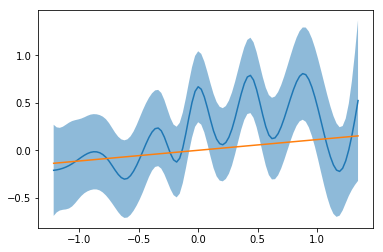

In [36]:
plot_prf(linear_gam, 0, res.params[1])

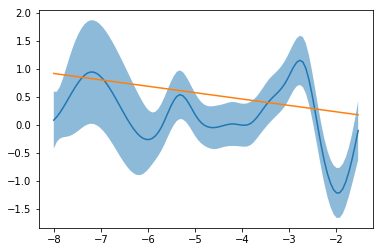

In [37]:
plot_prf(linear_gam, 1, res.params[2])

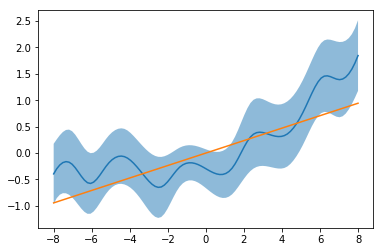

In [38]:
plot_prf(linear_gam, 3, res.params[4])

Appendix: Analysis of hypothesized mediators

Is there a difference in the discriminability of Democrats and Republicans?

In [39]:
ddiffs = participant_diff(np.arange(len(data))[data.party == "Democrat"])
rdiffs = participant_diff(np.arange(len(data))[data.party == "Republican"])
print np.mean(rdiffs) - np.mean(ddiffs)
cm = sms.CompareMeans(sms.DescrStatsW(rdiffs), sms.DescrStatsW(ddiffs))
cm.ttest_ind(usevar="unequal")

-0.009113493024315439


(-0.11037674105419748, 0.9123805369639919, 81.92708472834495)

$accurate \sim logodds + log(P) + party\_id + valence + party\_id \times valence \times sign(word) + party\_identity + party\_id \times party\_identity + political\_engagement + party\_id \times political\_engagement + \ldots{}$

In [40]:
n_vars = 9

Y_full = np.ravel(lr_data[ixs])
Y = Y_full > 2.5
X = np.full((n * len(ixs), n_vars + n - 1), np.nan)
# The log odds that the word was said by a Republican
vf = np.vectorize(lambda word: signals.loc[word]["rmetric"])
s = vf(np.ravel(lr_data[pair_cols]))
X[:,0] = np.abs(s)
# The log probability of hearing the word
vf = np.vectorize(lambda word: math.log(sum(freq_df.loc[(word,["dmetric","rmetric"])].values) / n_utterances, 2))
X[:,1] = vf(np.ravel(lr_data[pair_cols]))
# Participant's political identity
vf = np.vectorize(lambda pid: 1 if pid == "Republican" else -1 if pid == "Democrat" else 0
                 )
pids = np.repeat(vf(lr_data.party), len(ixs))
X[:,2] = pids
# Valence of word
vf = np.vectorize(lambda word: get_valence(word)[0]-5)
X[:,3] = vf(np.ravel(lr_data[pair_cols]))
# Valence of word * Participant's party identity * Word is Republican
X[:,4] = pids * X[:,3] * np.sign(s) 
# Party identity
X[:,5] = np.repeat(lr_data.party_identity, len(ixs))
# Party affiliation x party identity
X[:,6] = pids * X[:,5]
# Political engagement
X[:,7] = np.repeat(lr_data.political_engagement, len(ixs))
# Party affiliation x political engagement
X[:,8] = pids * X[:,7]
# Participant IDs
for i in range(n_vars, n_vars + n - 1):
    X[:,i] = np.repeat(lr_data["participant{}".format(i-n_vars+1)], len(ixs))

vf = np.vectorize(lambda word: signals.loc[word]["rmetric"] > 0)
polarity = vf(np.ravel(lr_data[pair_cols]))
Y = (Y & polarity) | (~Y & ~polarity)

Y = Y[~np.isnan(Y_full)]
X = X[~np.isnan(Y_full)]
Y_full = Y_full[~np.isnan(Y_full)]
X = X[~np.isnan(Y)]
Y_full = Y_full[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]
Y = Y[~np.isnan(X).any(axis = 1)]
Y_full = Y_full[~np.isnan(X).any(axis = 1)]
X = X[~np.isnan(X).any(axis = 1),:]
X = stats.mstats.zscore(X)

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [41]:
logit = SparseLR(Y, X); logit.coef[:n_vars], logit.n, logit.auc

(array([ 0.09243216, -0.34976423,  0.0766671 , -0.21365274,  0.41057134,
         0.01847488,  0.        ,  0.        ,  0.        ]),
 2498,
 0.6917592535281011)